In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
fig, ax = plt.subplots(figsize=(8,8))
points, = ax.plot(np.random.rand(10), 'o')
ax.set_ylim(0, 1)
N = 100;
x  = np.random.uniform(low=0, high=1, size=(N,))
y  = np.random.uniform(low=0, high=1, size=(N,))
def update(i):
    ax.clear()
    for i in range(len(x)):
        x[i] += np.random.uniform(-0.1,0.1)
        y[i] += np.random.uniform(-0.1,0.1)

        if(x[i] > 1.0): x[i] = 1;
        if(y[i] > 1.0): y[i] = 1;
    ax.scatter(x, y)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
     # reformat things
    ax.set_xlabel('x')
    ax.set_ylabel('y')

ani = animation.FuncAnimation(fig, update, frames = 30, interval=100)
ani.save('animation.mp4',fps=30,dpi=200);

In [2]:
######### SETUP SOLUTION FIELD #############
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

A = 0.1;
eps = 0.25;
w = (2*np.pi)/10;

@nb.jit(parallel=True)
def f(x,t):
    a = eps *np.sin(w*t);
    b = 1 - 2*eps*np.sin(w*t);
    return a*(x**2) + b*x;

@nb.jit(parallel=True)
def f_x(x,t):
    a = eps *np.sin(w*t);
    b = 1 - 2*eps*np.sin(w*t);
    return 2*a*x + b;

@nb.jit(parallel=True)
def solution(x,y,t):
    funX    = f(x,t);

    u       = -np.pi * A *np.sin(np.pi*funX)*np.cos(np.pi*y);
    v       = np.pi*A*np.cos(np.pi*funX)*np.sin(np.pi*y)*f_x(x,t);

    return [u,v]


def WriteTextFile(filename,count,gridX,gridY,Sol_U,Sol_V):
    fileFinalName = filename + str(count).zfill(4) + ".txt"

    with open(fileFinalName,"w") as f:
        
        for x,y,u,v in zip(gridX.transpose().flatten(),gridY.transpose().flatten(),Sol_U.transpose().flatten(),Sol_V.transpose().flatten()):
            f.write("{:e}".format(x) + "\t" + "{:e}".format(y) + "\t" + "{:e}".format(u) + "\t" + "{:e}".format(v) + "\n"  );
            

    f.close();
    



In [3]:
##### Computational Parameters ##############
## TIME PARAMETERS ###
startTime = 0;
endTime = 20;
timestep = 0.05;
currentTime = startTime;


## SPACE PARAMETERS ###
h = 0.03;
xMax = 2;
xMin = 0;
yMax = 1;
yMin = 0;
xArray = np.arange(xMin,xMax+h,h)
yArray = np.arange(yMin,yMax+h,h)

gridX,gridY = np.meshgrid(xArray,yArray);

MainSolutionArray_u =[];
MainSolutionArray_v =[];
MainSolution_Magnitude = [];
#### Solution Array 

filename = "gyre"
count = 0


while (currentTime < endTime):
    sol_u = np.zeros((len(xArray),len(yArray)));
    sol_v = np.zeros((len(xArray),len(yArray)));
    temp = [];
    # fff = open(filename + str(count)  + ".dat", "a")
    # fff.write(str("X,Y,U,V,|U| \n "));
    current_u,current_v = solution(gridX,gridY,currentTime)
    MainSolutionArray_u.append(current_u)
    MainSolutionArray_v.append(current_v)
    MainSolution_Magnitude.append(np.sqrt(current_u**2 + current_v**2))
    count +=1;
    currentTime += timestep;
    WriteTextFile("data/Velocity",count,gridX,gridY,current_u,current_v)


In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import numpy as np

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random


plt.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_u[1]**2 ),90,cmap="RdYlBu")
plt.streamplot(gridX,gridY,MainSolutionArray_u[0],MainSolutionArray_v[0],density = 0.65,integration_direction='both',color='black')

def update(i):
    global c, cf
    ax.clear()
    cf = ax.contourf(gridX,gridY,MainSolution_Magnitude[i],90,cmap="RdYlBu")
    ax.streamplot(gridX,gridY,MainSolutionArray_u[i],MainSolutionArray_v[i],density = 0.65,integration_direction='both',color='black')
    return ax,

fig, ax = plt.subplots(figsize=(8,4))
cf = ax.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_v[0]**2 ), cmap='RdYlBu',alpha=0.5)
c = ax.contour(gridX,gridY,MainSolution_Magnitude[0], colors='k',alpha=0.4)
ani = animation.FuncAnimation(fig, update, frames = 100)
ani.save('gyre.mp4',fps=15,dpi=150);

In [10]:
from scipy.interpolate import griddata

@nb.jit(nopython=True, parallel=True)
def updateParticleDisplacement(Particle_X,timestep,InterpolatedVelocityValues_u):
    newPosition = Particle_X + timestep* ( InterpolatedVelocityValues_u );
    return newPosition;

@nb.jit(nopython=True,parallel=True)
def updateFTLEScore(Particle_X,Particle_X_old,Particle_Y,Particle_Y_old,Particle_FTLE):
    global gridX,gridY
    for i in range( 1, len(Particle_X) -1):
            for j in range(1, len(Particle_X[0]) -1):
                # print(" i ", i , " j , ", j)
                # print("Par : " , Particle_X_old[i+1][j], " , ", Particle_X_old[i-1][j])
                a11 = 0;
                a12 = 0;
                a21 = 0;
                a22 = 0;
                if(abs(gridX[i+1][j] - gridX[i-1][j]) > 1e-6 ):
                    a11 = Particle_X[i+1][j] - Particle_X[i-1][j] / (gridX[i+1][j] - gridX[i-1][j] )
                if(abs(gridY[i][j+1] - gridY[i][j-1]) > 1e-6):
                    a12 =  Particle_X[i][j+1] - Particle_X[i][j-1] / (gridY[i][j+1] - gridY[i][j-1] )
                if(abs((gridX[i+1][j] - gridX[i-1][j] )) > 1e-6):
                    a21 = Particle_Y[i+1][j] - Particle_Y[i-1][j] / (gridX[i+1][j] - gridX[i-1][j] )
                if(abs((gridY[i][j+1] - gridY[i][j-1] )) > 1e-6):
                    a22 = Particle_Y[i][j+1] - Particle_Y[i][j-1] / (gridY[i][j+1] - gridY[i][j-1] )
                
                phi = np.array([[a11,a12],[a21,a22]]);
                Tensor = phi.transpose()@phi;

                Eigval = np.linalg.eigvals(Tensor);

                maxVal = np.max(Eigval);
                if(abs(maxVal) > 1e-6):
                    FTLE_Val  = (1/(abs(timestep))) * np.log(np.sqrt(maxVal));
                else:
                    FTLE_Val = 0;

                Particle_FTLE[i][j] = FTLE_Val;
    return Particle_FTLE;



def FTLETimeIntegration(currentTime,currentFrameIndex, FrameTimeStep, actualTimeStep , IntegrationTimeLength ,Particle_X,Particle_Y):
    
    global gridX, gridY;
    global MainSolutionArray_u ,MainSolutionArray_v;
    
    ##initialize Particle positions to Global Particle position as mentioned 
    particleX = gridX.copy();
    particleY = gridY.copy();
    
    steps = currentFrameIndex
    while ( steps < IntegrationTimeLength*FrameTimeStep + currentFrameIndex ):
        ##get the current velocity value for current position of particles
        
        interpolated_u = griddata()



        steps += FrameTimeStep;

    return 1


Done 0


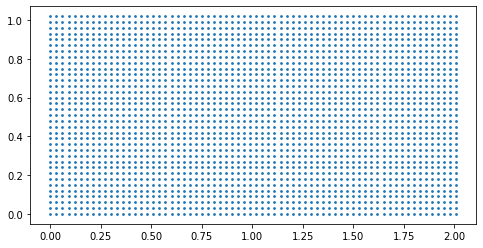

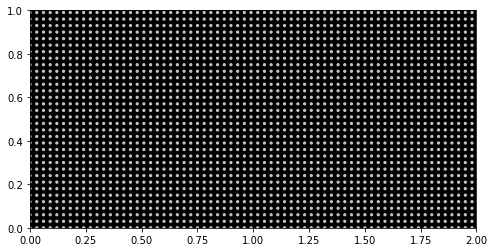

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49
Done 50
Done 51
Done 52
Done 53
Done 54
Done 55
Done 56
Done 57
Done 58
Done 59
Done 60
Done 61
Done 62
Done 63
Done 64
Done 65
Done 66
Done 67
Done 68
Done 69
Done 70
Done 71
Done 72
Done 73
Done 74
Done 75
Done 76
Done 77
Done 78
Done 79
Done 80
Done 81
Done 82
Done 83
Done 84
Done 85
Done 86
Done 87
Done 88
Done 89
Done 90
Done 91
Done 92
Done 93
Done 94
Done 95
Done 96
Done 97
Done 98
Done 99
Done 100
Done 101
Done 102
Done 103
Done 104
Done 105
Done 106
Done 107
Done 108
Done 109
Done 110
Done 111
Done 112
Done 113
Done 114
Done 115
Done 116
Done 117
Done 118
Done 119
Done 120
Done 121
Done 122
Done 123
D

In [6]:

from celluloid import Camera

#### function for INITIALISING PARTICLES IN THE DOMAIN 
## Initialise particles at every grid point 

Particle_X = gridX.copy();
Particle_Y = gridY.copy();
Particle_FTLE = np.zeros(Particle_X.shape)
Particle_ColorArray = np.empty(Particle_X.shape,dtype=object)

## Display the Particle Grid in Initial Position 
fig, ax = plt.subplots(figsize=(8,4))
# cf = ax.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_v[0]**2 ), cmap='RdYlBu',alpha=0.5)
particle = ax.scatter(Particle_X,Particle_Y,3)


### Advect the particles forward in time 
## Use trapezoidal Rule to obtain the Integration Value


FlattenGrid  = np.array( (gridX.flatten(), gridY.flatten()) ).T

fig, ax = plt.subplots(figsize=(8,4))
camera = Camera(fig)


for i in range(300):
    print("Done" , i)
    
    pointVel_u = MainSolutionArray_u[i].flatten();
    pointVel_v = MainSolutionArray_v[i].flatten();
    pointVel_u_next = MainSolutionArray_u[i+1].flatten();
    pointVel_v_next = MainSolutionArray_v[i+1].flatten();

    # pointVel_u = np.ones(MainSolutionArray_u[i].shape).flatten();
    # pointVel_v = np.ones(MainSolutionArray_v[i].shape).flatten();
    # pointVel_u_next = np.ones(MainSolutionArray_u[i+1].shape).flatten();
    # pointVel_v_next = np.ones(MainSolutionArray_v[i+1].shape).flatten();

    Particle_X_old = Particle_X.copy();
    Particle_Y_old = Particle_Y.copy();
    

    # print("Updaetd Disp" , i)
    # print(" Diff norm : ", np.linalg.norm(Particle_X - Particle_X_old , 2) )
    # print(" Diff norm Y : ", np.linalg.norm(Particle_Y - Particle_Y_old , 2) )
    # ax.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[i]**2 + MainSolutionArray_v[i]**2 ), cmap='RdYlBu',alpha=0.5)
    # ax.streamplot(gridX,gridY,MainSolutionArray_u[i],MainSolutionArray_v[i],density = 0.65,integration_direction='both',color='black')
    # ax.scatter(Particle_X,Particle_Y,color="black",s=5);
    # ax.set_xlim([0,2])
    # ax.set_ylim([0,1])
    # filename = "scatter_" + str(i) + ".png";
    # camera.snap();
    # plt.draw();
    # plt.show();

    # Compute Particle FTLE
    # get gradient 
    
    Particle_FTLE = updateFTLEScore(Particle_X,Particle_X_old,Particle_Y,Particle_Y_old,Particle_FTLE);
    # print("FTLE scre" , i)
    ## Apply color based on the maximum Range of the 
    maxFTLE  =  np.max(Particle_FTLE);
    colorArray = [['#C5C5C5' for x in range(len(Particle_FTLE[0]))] for y in range(len(Particle_FTLE))]
    colorArray =  np.array(colorArray)
    for i in range(len(Particle_FTLE)):
        for j in range(len(Particle_FTLE[0])):
            if(Particle_FTLE[i][j] > 0.5*maxFTLE):
                colorArray[i][j] = '#FF2D00';
            elif (Particle_FTLE[i][j] > 0.25*maxFTLE):
                colorArray[i][j] = '#03BB00';
            else:
                colorArray[i][j] = '#C5C5C5'
    # print("Color" , i)
    ax.scatter(Particle_X.flatten(),Particle_Y.flatten(),color=colorArray.flatten(),s=5);
    ax.set_facecolor('black')
    ax.set_xlim([0,2])
    ax.set_ylim([0,1])
    camera.snap();
    plt.show();

animation = camera.animate()
animation.save('FTLE.mp4') 
print("Figure Saved ")

In [7]:
np.max(Particle_FTLE)



0.0

51.562955047328906
26.834511459432505


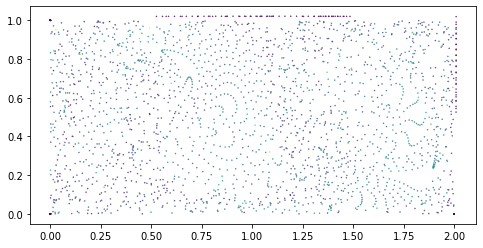

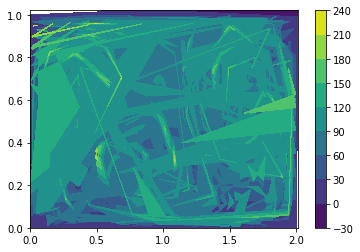

In [42]:
## Display the Particle Grid in Initial Position 
fig, ax = plt.subplots(figsize=(8,4))
# cf = ax.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_v[0]**2 ), cmap='RdYlBu',alpha=0.5)
particle = ax.scatter(Particle_X,Particle_Y,c=Particle_FTLE,s=0.2)
print(np.linalg.norm(Particle_X,2))
print(np.linalg.norm(Particle_Y,2))
plt.show();


plt.contourf(Particle_X,Particle_Y,Particle_FTLE)
plt.colorbar()

In [69]:
## Write to Tecplot file 
Headers = ["x","y" , "FLTE"]
def writeToTecplotFile(Headers,xPos,yPos,val,fileName,count):
    readMode = 'a'
    if(count):
        fileFinalName = fileName + "_" + str(count) +"_" + ".dat";
        readMode = 'a'
    else:
        fileFinalName = fileName + ".dat";
        readMode = 'w'

    


    with open(fileFinalName,readMode) as f:
        if(count):
            f.write("TITLE : FTLE")
        
        l ='VARIABLES = ';
        for k in Headers:
            l += '"' + k + '",';

        f.write(l[:-1] + "\n");

        l = """Zone T = psi I = """  + str("{:e}".format(xPos.shape[0])) +  """ J = """ + str("{:e}".format(xPos.shape[1]));
        f.write(l+ "\n")

        l = """StrandID =1, SolutionTime = """ + str(count);
        f.write(l+ "\n");

        xPos = xPos.flatten();
        yPos = yPos.flatten();
        val = val.flatten();

        for x,y,val in zip(xPos,yPos,val):
            f.write( "{:e}".format(x) + "\t" + "{:e}".format(y) + "\t"  + "{:e}".format(val) + "\n")
        



writeToTecplotFile(Headers,Particle_X,Particle_Y,Particle_FTLE,"test",0)


In [8]:
Solx= np.arange(1,16).reshape((5,3))
Soly= np.arange(2,17).reshape((5,3))
from scipy.interpolate import griddata

X = np.arange(0,2+0.5,0.5);
Y = np.arange(0,1+0.5,0.5);

xx,yy = np.meshgrid(X,Y)

points = np.array( (xx.flatten(), yy.flatten()) ).T
# print(points)
values =  Solx.flatten()
# print(values)
Z0 = griddata( points, values, (xx,yy) )
print(Z0)

[[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]]


In [48]:
Headers = ["x","y" , "FLTE"]
",".join((""" "  """,Headers,""" "  """))

TypeError: sequence item 1: expected str instance, list found

In [51]:
l = "VARIABLES = "
l[:-1]

'VARIABLES ='

In [63]:
a = ["apple","Bannana"]
b = ["Sucks","yummy"]

for i,j in zip(a,b):
    print(i,",",j)

apple , Sucks
Bannana , yummy
